# DEA Intertidal Elevation validation

This notebook calculates validation statistics for DEA Intertidal Elevation by comparing elevation values against external validation LiDAR and multibeam datasets.

<div class="alert alert-info">

**Note:** This is an experimental notebook containing preliminary validation results. These results will be updated upon publication of the DEA Intertidal Elevation scientific paper.

</div>

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


In [ ]:
pip install -r requirements.in --quiet

In [ ]:
pip install xarray-spatial

In [11]:
%load_ext autoreload
%autoreload 2

import glob 
import rioxarray
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.errors import RasterioIOError
import warnings
warnings.filterwarnings("ignore")

import datacube
import odc.geo.xr
from odc.geo.geobox import GeoBox
from odc.geo.geom import BoundingBox, Geometry
from dea_tools.datahandling import load_reproject
from dea_tools.dask import create_local_dask_cluster
from dea_tools.validation import eval_metrics

from intertidal.validation import map_raster, preprocess_validation

dc = datacube.Datacube()

client = create_local_dask_cluster(return_client=True)

## Validation sites from polygons

In [3]:
# Set up data paths
resampling="average"
resolution=10

# Load polygons
validation_sites_gdf = gpd.read_file("data/raw/validation_sites.geojson")
validation_sites_gdf["mod_path"] = "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/virtual_rasters/DEV_2019_2021_elevation.vrt"
validation_sites_gdf["val_path"] = "/gdata1/projects/coastal/intertidal/Elevation_data/Processed/" + validation_sites_gdf.year + "_combined.tif"


In [13]:
outputs = []

for i, row in tqdm(
    validation_sites_gdf.iterrows(), total=len(validation_sites_gdf.index)
):
    try:
        # Convert to Geometry and create GeoBox to load data into
        poly = Geometry(row.geometry, crs="EPSG:4326")
        poly_geobox = odc.geo.geobox.GeoBox.from_geopolygon(
            poly, crs="EPSG:3577", resolution=resolution
        )

        # Load from datacube
        dss = dc.find_datasets(
            product="ga_s2ls_intertidal_cyear_3",
            time=row.year,
            like=poly_geobox.compat,
        )
        tr = np.mean([i.metadata.search_fields["intertidal_tr"] for i in dss])
        otr = np.mean([i.metadata.search_fields["intertidal_otr"] for i in dss])
        lat = np.mean([i.metadata.search_fields["intertidal_lat"] for i in dss])
        hat = np.mean([i.metadata.search_fields["intertidal_hat"] for i in dss])

        modelled_ds = (
            dc.load(
                datasets=dss,
                like=poly_geobox.compat,
                measurements=["elevation", "uncertainty"],
                dask_chunks={"x": 2048, "y": 2048},
                resampling=resampling,
            )
            .squeeze("time")
            .compute()
        )
        modelled_da = modelled_ds.elevation
        uncertainty_da = modelled_ds.uncertainty

        # modelled_ds = dc.load(
        #             product="nidem",
        #             like=poly_geobox.compat,
        #             dask_chunks={"x": 2048, "y": 2048},
        #             resampling=resampling,
        #         ).squeeze("time").compute()
        # modelled_da = modelled_ds.nidem

        # Skip polygon if no modelled data available
        if (~modelled_da.isnull()).sum().item() > 0:
            # Load validation data into polygon GeoBox
            validation_da = load_reproject(
                path=row.val_path, how=poly_geobox, resampling=resampling
            ).compute()

            # Mask our data by our input polygon
            modelled_da = modelled_da.odc.mask(poly=poly)

            # Preprocess
            validation_m, modelled_m, uncertainty_m = preprocess_validation(
                validation_da,
                modelled_da,
                uncertainty_da,
                lat=lat,
                hat=hat,
            )

            output_df = pd.DataFrame(
                {
                    "i": i,
                    "year": row.year,
                    "tr": tr,
                    "otr": otr,
                    "lat": lat,
                    "hat": hat,
                    "validation_m": validation_m,
                    "modelled_m": modelled_m,
                    "uncertainty_m": uncertainty_m,
                }
            )
            outputs.append(output_df)

    except (KeyError, RasterioIOError, IndexError, AssertionError):
        pass

# Combine and add additional columns
outputs_all_df = pd.concat(outputs)
outputs_all_df["uncertainty_perc"] = outputs_all_df.uncertainty_m / outputs_all_df.tr
outputs_all_df["category"] = pd.cut(
    outputs_all_df.tr,
    bins=(0, 2, 4, np.inf),
    labels=["microtidal", "mesotidal", "macrotidal"],
)

 66%|██████▌   | 321/486 [02:23<01:52,  1.46it/s]/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
100%|██████████| 486/486 [08:31<00:00,  1.05s/it]


## Results

### Overall

Correlation         0.881
RMSE                0.271
MAE                 0.210
R-squared           0.776
Bias                0.157
Regression slope    0.842
dtype: float64
n                   3160364
area                316.04 km sq


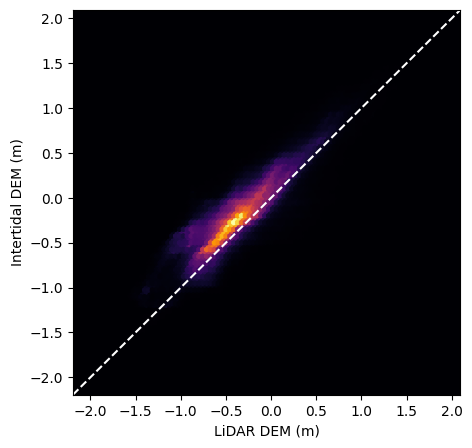

In [33]:
# Plot and compare - heatmap
plt.figure(figsize=(5, 5))
lim_min, lim_max = np.percentile(
    np.concatenate([outputs_all_df.validation_m, outputs_all_df.modelled_m]), [1, 99]
)
lim_min -= 1
lim_max += 1
plt.hexbin(
    x=outputs_all_df.validation_m,
    y=outputs_all_df.modelled_m,
    extent=(lim_min, lim_max, lim_min, lim_max),
    cmap="inferno",
)
plt.gca().set_facecolor("#0C0C0C")
plt.plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
plt.margins(x=0, y=0)
plt.xlabel("LiDAR DEM (m)")
plt.ylabel("Intertidal DEM (m)")

# Accuracy statistics
print(eval_metrics(x=outputs_all_df.validation_m, y=outputs_all_df.modelled_m, round=3))
print(f"n                   {len(outputs_all_df.modelled_m)}")
print(f"area                {len(outputs_all_df.modelled_m) * (10 * 10) * 0.000001:.2f} km sq")


In [40]:
fig.savefig("DEAIntertidal_validation_all.png", dpi=200, bbox_inches="tight")

#### Assorted plots

<Axes: xlabel='year'>

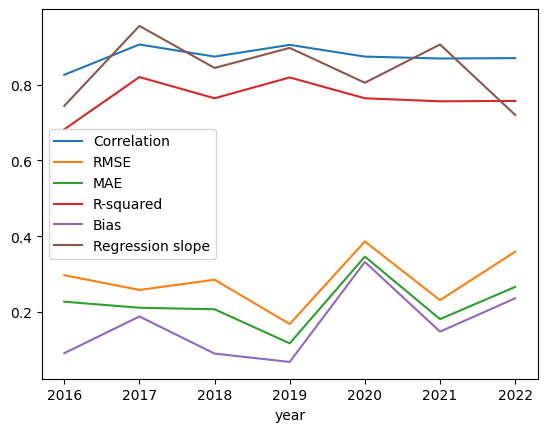

In [34]:
outputs_all_df.groupby("year").apply(lambda x: eval_metrics(x=x.validation_m, y=x.modelled_m, round=3)).plot()

<Axes: xlabel='year'>

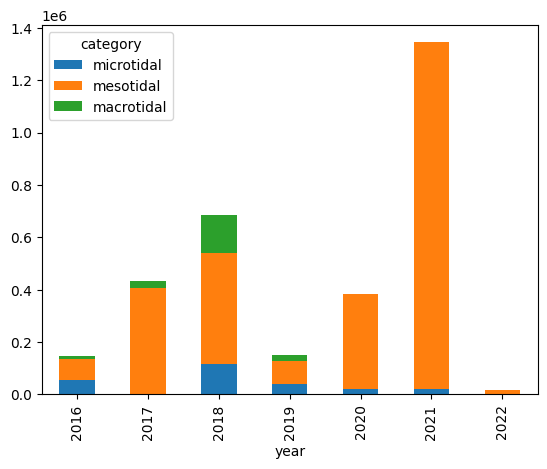

In [35]:
outputs_all_df.groupby(["year", "category"]).validation_m.count().unstack(level=-1).plot.bar(stacked=True)

### By certainty

Correlation         0.907
RMSE                0.235
MAE                 0.185
R-squared           0.823
Bias                0.145
Regression slope    0.863
dtype: float64
n                   1900080
area                190.01 km sq
Correlation         0.862
RMSE                0.308
MAE                 0.242
R-squared           0.743
Bias                0.178
Regression slope    0.822
dtype: float64
n                   1120065
area                112.01 km sq
Correlation         0.792
RMSE                0.390
MAE                 0.299
R-squared           0.628
Bias                0.145
Regression slope    0.801
dtype: float64
n                   140219
area                14.02 km sq


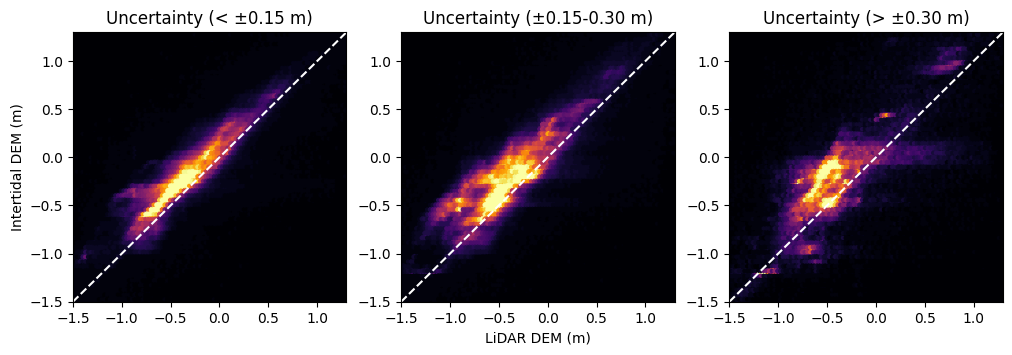

In [36]:
lim_min, lim_max = np.percentile(
    np.concatenate([outputs_all_df.validation_m, outputs_all_df.modelled_m]), [1, 99]
)
lim_min -= 0.1
lim_max += 0.1

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

# Define a set of certainty ranges
cert_ranges = [(0, 0.15), (0.15, 0.3), (0.3, 10)]
scale_dict = [(-1.5, 1.3), (-1.5, 1.3), (-1.5, 1.3)]
titles = ["Uncertainty (< ±0.15 m)", "Uncertainty (±0.15-0.30 m)", "Uncertainty (> ±0.30 m)"]

out = {}
for i, (min_thresh, max_thresh) in enumerate(cert_ranges):
    outputs_subset_df = outputs_all_df.query(
        "(uncertainty_perc >= @min_thresh) & (uncertainty_perc < @max_thresh)"
    )
    outputs_subset_df = outputs_all_df.query(
        "(uncertainty_m >= @min_thresh) & (uncertainty_m < @max_thresh)"
    )
    
    lim_min, lim_max = scale_dict[i]

    # Plot and compare - heatmap
    axes[i].hexbin(
        x=outputs_subset_df.validation_m,
        y=outputs_subset_df.modelled_m,
        extent=(lim_min, lim_max, lim_min, lim_max),
        cmap="inferno",
        bins=100,
        vmin=0,
        vmax=50,
    )
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white")
    axes[i].margins(x=0, y=0)
    axes[i].set_title(titles[i])
    if i == 0:
        axes[i].set_ylabel("Intertidal DEM (m)")
    elif i == 1:
        axes[i].set_xlabel("LiDAR DEM (m)")

    # Accuracy statistics
    print(
        eval_metrics(
            x=outputs_subset_df.validation_m, y=outputs_subset_df.modelled_m, round=3
        )
    )
    print(f"n                   {len(outputs_subset_df.modelled_m)}")
    print(f"area                {len(outputs_subset_df.modelled_m) * (10 * 10) * 0.000001:.2f} km sq")

In [37]:
fig.savefig("DEAIntertidal_validation_uncertainty.png", dpi=200, bbox_inches="tight")

### By tide range class

Correlation         0.596
RMSE                0.275
MAE                 0.212
R-squared           0.355
Bias                0.142
Regression slope    0.435
dtype: float64
n                   259348
area                25.93 km sq
Correlation         0.861
RMSE                0.270
MAE                 0.211
R-squared           0.741
Bias                0.161
Regression slope    0.803
dtype: float64
n                   2696399
area                269.64 km sq
Correlation         0.957
RMSE                0.282
MAE                 0.199
R-squared           0.917
Bias                0.122
Regression slope    1.025
dtype: float64
n                   204617
area                20.46 km sq


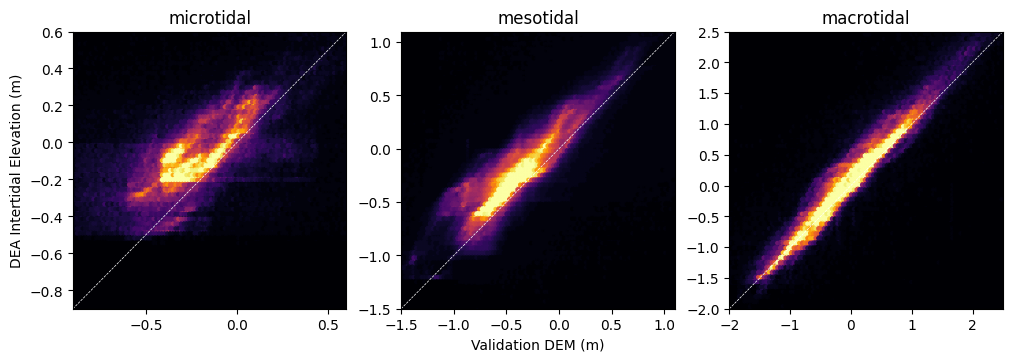

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))

# Define a set of certainty ranges
cat_ranges = ["microtidal", "mesotidal", "macrotidal"] 

scale_dict = {"microtidal": (-0.9, 0.6), "mesotidal": (-1.5, 1.1), "macrotidal": (-2, 2.5)}

out = {}
for i, cat in enumerate(cat_ranges):
    outputs_subset_df = outputs_all_df.query("category == @cat")    

    lim_min, lim_max = scale_dict[cat]

    # Plot and compare - heatmap
    axes[i].hexbin(
        x=outputs_subset_df.validation_m,
        y=outputs_subset_df.modelled_m,
        extent=(lim_min, lim_max, lim_min, lim_max),
        cmap="inferno",
        bins=100,
        vmin=0,
        vmax=50,
    )
    axes[i].set_facecolor("#0C0C0C")
    axes[i].plot([lim_min, lim_max], [lim_min, lim_max], "--", c="white", linewidth=0.5)
    axes[i].margins(x=0, y=0)
    axes[i].set_title(cat)
    if i == 0:
        axes[i].set_ylabel("DEA Intertidal Elevation (m)")
    elif i == 1:
        axes[i].set_xlabel("Validation DEM (m)")

    # Accuracy statistics
    print(
        eval_metrics(
            x=outputs_subset_df.validation_m, y=outputs_subset_df.modelled_m, round=3
        )
    )
    print(f"n                   {len(outputs_subset_df.modelled_m)}")
    print(f"area                {len(outputs_subset_df.modelled_m) * (10 * 10) * 0.000001:.2f} km sq")

In [39]:
fig.savefig("DEAIntertidal_validation_micromesomacro.png", dpi=200, bbox_inches="tight")